# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [5]:
rides = pd.read_csv('Bike-Sharing-Dataset/hour.csv')

In [6]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days in the data set. You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

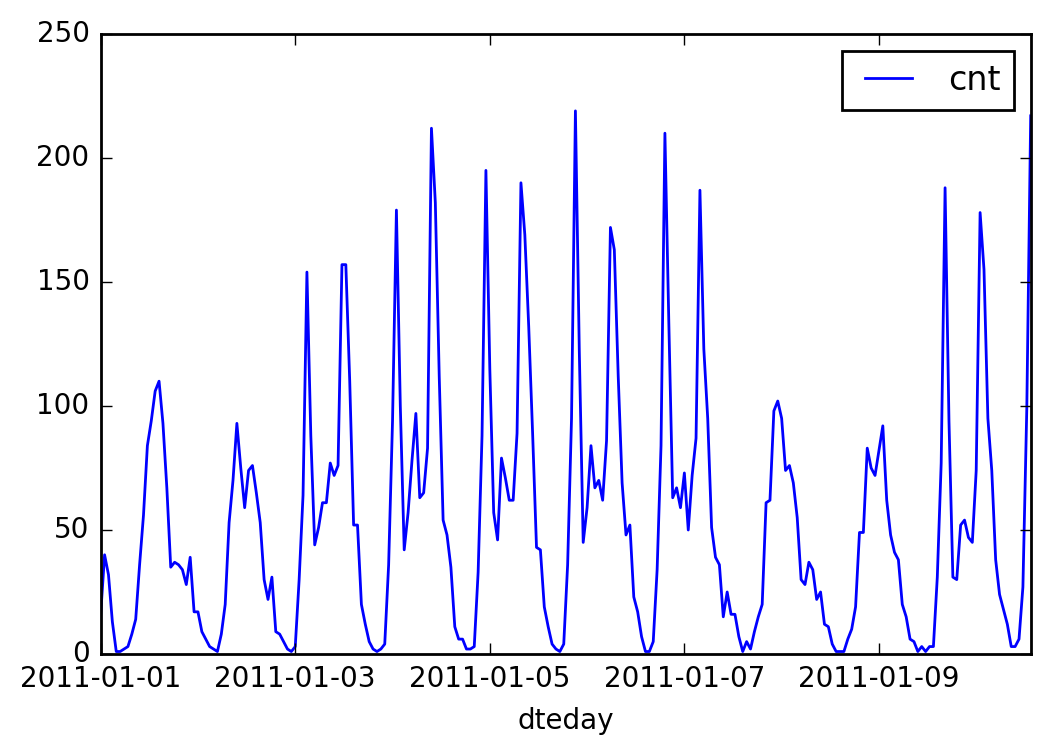

In [7]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [8]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
data.columns

Index([u'yr', u'holiday', u'temp', u'hum', u'windspeed', u'casual',
       u'registered', u'cnt', u'season_1', u'season_2', u'season_3',
       u'season_4', u'weathersit_1', u'weathersit_2', u'weathersit_3',
       u'weathersit_4', u'mnth_1', u'mnth_2', u'mnth_3', u'mnth_4', u'mnth_5',
       u'mnth_6', u'mnth_7', u'mnth_8', u'mnth_9', u'mnth_10', u'mnth_11',
       u'mnth_12', u'hr_0', u'hr_1', u'hr_2', u'hr_3', u'hr_4', u'hr_5',
       u'hr_6', u'hr_7', u'hr_8', u'hr_9', u'hr_10', u'hr_11', u'hr_12',
       u'hr_13', u'hr_14', u'hr_15', u'hr_16', u'hr_17', u'hr_18', u'hr_19',
       u'hr_20', u'hr_21', u'hr_22', u'hr_23', u'weekday_0', u'weekday_1',
       u'weekday_2', u'weekday_3', u'weekday_4', u'weekday_5', u'weekday_6'],
      dtype='object')

### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [10]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    print("each_feature:",each,"mean:",mean,"std:",std)
    scaled_features[each] = [mean, std]  #dictionary
    data.loc[:, each] = (data[each] - mean)/std  #all  row for  each  feature: standardize
#     print("*",data.loc[:, each])

('each_feature:', 'casual', 'mean:', 35.676218424535357, 'std:', 49.30503038705308)
('each_feature:', 'registered', 'mean:', 153.78686920996606, 'std:', 151.35728591258314)
('each_feature:', 'cnt', 'mean:', 189.46308763450142, 'std:', 181.38759909186473)
('each_feature:', 'temp', 'mean:', 0.4969871684216583, 'std:', 0.19255612124972191)
('each_feature:', 'hum', 'mean:', 0.6272288394038783, 'std:', 0.19292983406291508)
('each_feature:', 'windspeed', 'mean:', 0.1900976063064618, 'std:', 0.12234022857279049)


In [11]:
#my
print(mean, std)

(0.1900976063064618, 0.12234022857279049)


In [12]:
#my
print(type(scaled_features), scaled_features)

(<type 'dict'>, {'cnt': [189.46308763450142, 181.38759909186473], 'temp': [0.4969871684216583, 0.19255612124972191], 'hum': [0.6272288394038783, 0.19292983406291508], 'registered': [153.78686920996606, 151.35728591258314], 'windspeed': [0.1900976063064618, 0.12234022857279049], 'casual': [35.676218424535357, 49.30503038705308]})


### Splitting the data into training, testing, and validation sets

We'll save the last 21 days of the data to use as a validation set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [13]:
# #my test just 0.2day
# # Save the last 21 days 
# validation = data[-0.2*24:]
# data = data[:-0.2*24]
# #my
# print(validation.head(3),validation.size)
# print("#"*33)
# print(data.head(3),data.size)

# # Separate the data into features and targets
# target_fields = ['cnt', 'casual', 'registered']
# features, targets = data.drop(target_fields, axis=1), data[target_fields]
# val_features, val_targets = validation.drop(target_fields, axis=1), validation[target_fields]

In [14]:
# Save the last 21 days 
validation = data[-21*24:]
data = data[:-21*24]
#my
print(validation.head(3),validation.size)
print("#"*33)
print(data.head(3),data.size)

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
val_features, val_targets = validation.drop(target_fields, axis=1), validation[target_fields]

(       yr  holiday      temp       hum  windspeed    casual  registered  \
16875   1        0  0.015647  0.999178   0.276298 -0.500481   -0.256260   
16876   1        0 -0.192085  1.310171   0.519881 -0.561326   -0.513929   
16877   1        0 -0.192085  0.740016   2.228232 -0.683018   -0.824452   

            cnt  season_1  season_2    ...      hr_21  hr_22  hr_23  \
16875 -0.349876         0         0    ...          0      1      0   
16876 -0.581424         0         0    ...          0      0      1   
16877 -0.873616         0         0    ...          0      0      0   

       weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  \
16875          0          1          0          0          0          0   
16876          0          1          0          0          0          0   
16877          0          0          1          0          0          0   

       weekday_6  
16875          0  
16876          0  
16877          0  

[3 rows x 59 columns], 29736)
#####

We'll split the data into two sets, one for training and one for testing as the network is being trained. It's important to split the data randomly so all cases are represented in both sets.

In [15]:
#my
print(features.shape,features.index)
features.head(3)

((16875, 56), RangeIndex(start=0, stop=16875, step=1))


,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [16]:
n_records = features.shape[0]  #number of  row
print("features.shape[0]:",n_records)
split = np.random.choice(features.index, 
                         size=int(n_records*0.8), 
                         replace=False)
train_features, train_targets = features.ix[split], targets.ix[split]
test_features, test_targets = features.drop(split), targets.drop(split)

('features.shape[0]:', 16875)


In [17]:
print(test_features.shape)
test_features.head(3)

(3375, 56)


,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
4,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
8,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
17,0,0,-0.295951,0.999178,0.764282,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
print(test_targets.shape)
test_targets.head(3)

(3375, 3)


,cnt,casual,registered
4,-1.039008,-0.723582,-1.009445
8,-1.000416,-0.703300,-0.969804
17,-0.675146,-0.419353,-0.672494


## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. . You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is  f(x)=xf(x)=x . A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called Forward Propagation.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called Backpropagation.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [64]:
#my
epochs = 10000
learning_rate = 0.001
hidden_nodes = 200
output_nodes = 1

N_i = train_features.shape[1] #56
print("train_features.shape[1]:",N_i)
# # network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)
# # class NeuralNetwork:
# #    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
# #         # Set number of nodes in input, hidden and output layers.
# #         self.input_nodes = input_nodes
# #         self.hidden_nodes = hidden_nodes
# #         self.output_nodes = output_nodes
print ("self.weights_input_to_hidden:\n")
print (np.random.normal(0.0, hidden_nodes**-0.5, 
                                       (hidden_nodes, N_i)))  
print ("*",np.random.normal(0.0, hidden_nodes**-0.5, 
                                       (hidden_nodes, N_i)).shape)   
print ("self.weights_hidden_to_output:\n")
print (np.random.normal(0.0, output_nodes**-0.5, 
                                       (output_nodes, hidden_nodes)))
print ("**",np.random.normal(0.0, output_nodes**-0.5, 
                                       (output_nodes, hidden_nodes)).shape)
# x = np.array([[0,0,1],
#               [0,1,1],
#               [1,0,1],
#               [1,1,1]])
# def actf(x):
#     activation_function = lambda x: 1/(1+np.exp(-x))

# print (actf(x))

('train_features.shape[1]:', 56)
self.weights_input_to_hidden:

[[ 0.004678    0.15112432  0.06290653 ..., -0.03531141 -0.12913069
  -0.1065262 ]
 [-0.02016091 -0.08887672  0.02359884 ...,  0.06754856  0.1052024
  -0.02240392]
 [ 0.12195771 -0.05126973  0.0424906  ...,  0.05515262  0.00627951
   0.09106578]
 ..., 
 [-0.10162526  0.02171942 -0.02274522 ...,  0.03041225 -0.05234651
  -0.00551254]
 [-0.17722804 -0.03100065  0.03723787 ..., -0.08132758 -0.03350912
  -0.01230299]
 [-0.00259154 -0.09167994 -0.00409214 ...,  0.05949591  0.10434355
  -0.0092578 ]]
('*', (200, 56))
self.weights_hidden_to_output:

[[-1.41840866 -0.00968539 -0.39600891 -0.28887754  0.23318111 -1.10753518
  -0.37570227 -1.13468042 -1.11504436 -0.04643997 -0.33050276 -0.60807938
  -1.21916103 -0.63780701 -0.07809263  1.6905101  -0.41310866  0.18975631
   0.5168714  -0.76330996  1.05632144  0.39506553 -0.78426338  0.60761743
  -1.02394754 -1.60860718 -1.95174395  1.13354646 -0.93536786  0.39487095
   0.00577092 -0.4

In [73]:
#sigmoid  function  test
hidden_inupt1=np.array(
      [[ 1.16888254],
       [ 1.09198465],
       [-0.84237632],
       [-0.68582608],
       [-0.12797966]])
hidden_output1=np.array(
       [[ 0.76294297],
       [ 0.74875526],
       [ 0.30103454],
       [ 0.33496222],
       [ 0.46804868]]) 
print(1/(1+np.exp(-hidden_inupt1)))


[[ 0.76294297]
 [ 0.74875526]
 [ 0.30103454]
 [ 0.33496222]
 [ 0.46804868]]
No


In [82]:
t2 = np.arange(200).reshape(200,1)
# aa1=t2*(1-t2)
# print(aa1,aa1.shape)
print((t2*t2).shape)

(200, 1)


In [95]:
ttt3=np.arange(13500*56).reshape(13500,56)
ttt4=np.array(ttt3, ndmin=2).T
print(ttt4.shape)

(56, 13500)


In [20]:
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights 
        #(200, 56)   #number of hidden node : 200
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))
        #(1, 200)
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        #### Set this to your implemented sigmoid function ####
        # Activation function is the sigmoid function
        self.activation_function = lambda x: 1/(1+np.exp(-x))
    
    def train(self, inputs_list, targets_list):  #((128,56) , (128,))
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T  #(56.1)
#         print("inputs:",inputs.shape)
        targets = np.array(targets_list, ndmin = 2).T  #(1,1)
#         print("targets:",targets.shape)
        #### Implement the forward pass here ####
        ### Forward pass ###
        # Hidden layer
        #(200, 56) dot (56,1) makes  (200,1)
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
#         print("hidden_inputs:",hidden_inputs)
## sigmoid OK
        #  hidden_outputs(200,1)      <- hidden_inputs  (200,1)
        hidden_outputs = self.activation_function(hidden_inputs)
#         print("hidden_outputs:",hidden_outputs)
        # Output layer
        #          (1,1)    <-      (1,200) dot (200,1)     
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        

        final_outputs = self.activation_function(final_inputs)  #(1,1)
        
        ### Backward pass ###
        # Output error(1,1) <- (1,1)-(1,1)
        output_errors = targets - final_outputs
        
        # Backpropagated error
        #  hidden_errors   (200,1)       <-  (200,1) dot (1,1)
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors)
        
        # (200,1)   <-        (200,1)*(1.0 -(200,1))          
        hidden_grad = hidden_outputs * (1.0 - hidden_outputs)
        
        # Update the weights
        #    (1,200)             <-                   (1,1) dot (1,200)
        self.weights_hidden_to_output += self.lr * np.dot(output_errors, 
                                                          hidden_outputs.T)
        #                                         (200,1)*(200,1) is(200,1),so (200,1)
        #                                 so  (200,1) dot ()
        self.weights_input_to_hidden += self.lr * np.dot(hidden_errors * hidden_grad, inputs.T)
    # actual run() variable  is  train_features, (13500, 56)
    def run(self, inputs_list): 
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T #(56,1)
        
        #### Implement the forward pass here ####
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)

#This is our prediction step. Basically, we first let the network "try" to predict the output given the input.         
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs

In [22]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Here you'll set the hyperparameters for the network. You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network much faster. You'll learn more about SGD later.

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. However, it can become too specific to the training set and will fail to generalize to the test set. This is called overfitting. You'll need to choose enough epochs to train the network well but not too many or you'll be overfitting.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance.

In [60]:
#my
print(train_features.index, train_features.shape)
#randomly selcect 5 index number of  features
batch=np.random.choice(train_features.index, size=5)  
print("batch:",batch)
print("##train_features.iloc[2255]: ")
print(train_features.iloc[2255])
print("*"*55)
#(5, 56)
print(train_features.ix[batch].values,train_features.ix[batch].values.shape) 
print("$$",train_features.ix[batch].values[0].shape) #(56,)
print("*"*55)
#(5,)
print(train_targets.ix[batch]['cnt'],train_targets.ix[batch]['cnt'].shape)

(Int64Index([12375,  4678, 11599,  2118,   471, 10674,  5620,  1973,  1979,
             4344,
            ...
            10428,  5179,  2177,  3874,  5883,  3443,  9594, 10127, 11703,
             9357],
           dtype='int64', length=13500), (13500, 56))
('batch:', array([14022, 13649,  6771,  3987, 11990]))
##train_features.iloc[2255]: 
yr              1.000000
holiday         0.000000
temp           -0.919146
hum             0.688184
windspeed      -0.456086
season_1        0.000000
season_2        1.000000
season_3        0.000000
season_4        0.000000
weathersit_1    0.000000
weathersit_2    1.000000
weathersit_3    0.000000
weathersit_4    0.000000
mnth_1          0.000000
mnth_2          0.000000
mnth_3          0.000000
mnth_4          1.000000
mnth_5          0.000000
mnth_6          0.000000
mnth_7          0.000000
mnth_8          0.000000
mnth_9          0.000000
mnth_10         0.000000
mnth_11         0.000000
mnth_12         0.000000
hr_0            1.000000
hr_1 

In [103]:
aaa1=np.arange(128*56).reshape(128,56)
aaa2=np.arange(128).reshape(128,)
print(aaa1.shape)
print(aaa2.shape)
print("zip(aaa1,aaa2).shape",len(zip(aaa1,aaa2))) #('zip(aaa1,aaa2).shape', 128)
# print("zip(aaa1,aaa2)",zip(aaa1,aaa2))  #[((128,56),(128,)),((128,56),(128,)),...]
for i2, j2 in zip(aaa1,aaa2):
    # Convert inputs list to 2d array
        inputs2 = np.array(i2, ndmin=2).T  #(56.1)
#         print("i2:",i2,"inputs:",inputs2.shape)
        targets2 = np.array(j2, ndmin = 2).T  #(1,1)
#         print("j2:",j2,"targets:",targets2.shape)

(128, 56)
(128,)
('zip(aaa1,aaa2).shape', 128)


('zip(aaa1,aaa2)', [(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55]), 0), (array([ 56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111]), 1), (array([112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167]), 2),...]

In [100]:
### Set the hyperparameters here ###
epochs = 10000
learning_rate = 0.001
hidden_nodes = 200
output_nodes = 1

N_i = train_features.shape[1]  #56 -> input_features
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'test':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    ## train_features.shape -> (13500, 56)
    ##ex)batch - array([14022, 13649,  6771,  3987, 11990...],number ofindex is 128
    batch = np.random.choice(train_features.index, size=128)
    #                    zip( (128,56),(128,))
    for record, target in zip(train_features.ix[batch].values, train_targets.ix[batch]['cnt']):
        network.train(record, target)  #train function used here !
    
    if e%(epochs/10) == 0:
        # Calculate losses for the training and test sets
        # train_features.shape (13500, 56)
        train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
        test_loss = MSE(network.run(test_features), test_targets['cnt'].values)
        losses['train'].append(train_loss)
        losses['test'].append(test_loss)
        
        # Print out the losses as the network is training
        print('Training loss: {:.4f}'.format(train_loss))
        print('Test loss: {:.4f}'.format(test_loss))
        pass
        

Training loss: 0.9968
Test loss: 1.0166


/home/ys/.local/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: overflow encountered in exp


Training loss: 0.6755
Test loss: 0.6928
Training loss: 0.6435
Test loss: 0.6542
Training loss: 0.6237
Test loss: 0.6432
Training loss: 0.6143
Test loss: 0.6302
Training loss: 0.6076
Test loss: 0.6297
Training loss: 0.6102
Test loss: 0.6335
Training loss: 0.6086
Test loss: 0.6333
Training loss: 0.6051
Test loss: 0.6237
Training loss: 0.6034
Test loss: 0.6243


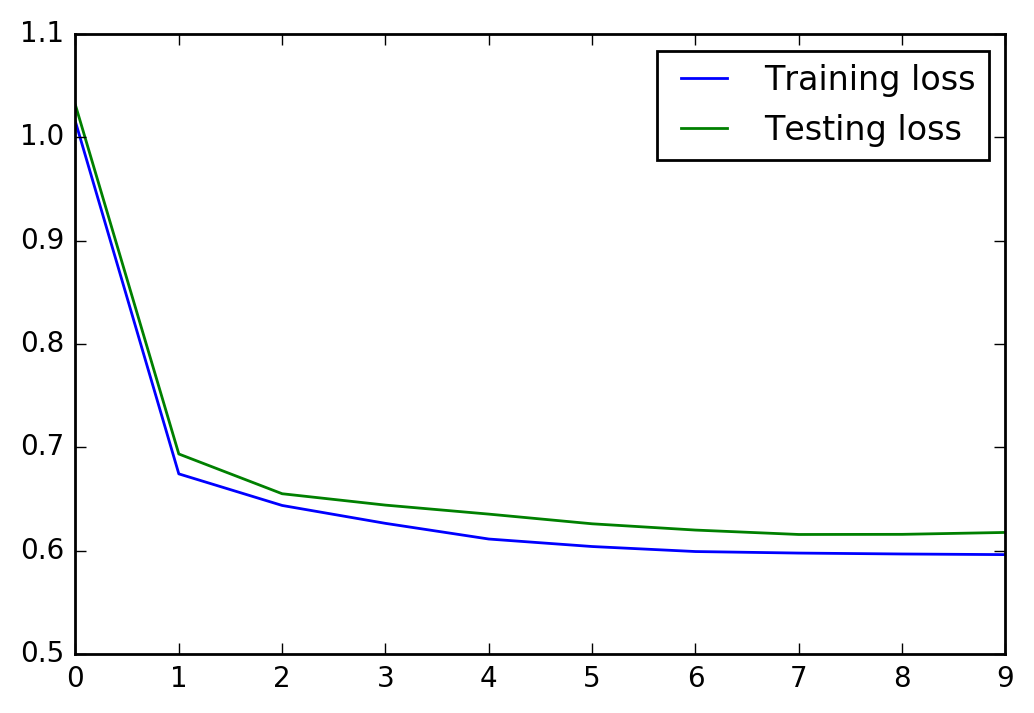

In [42]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['test'], label='Testing loss')
plt.legend()

## Check out your predictions

Here, use the validation data to check that network is accurately making predictions. If your predictions don't match the data, try adjusting the hyperparameters and check to make sure the forward passes in the network are correct.

/home/ys/.local/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: overflow encountered in exp


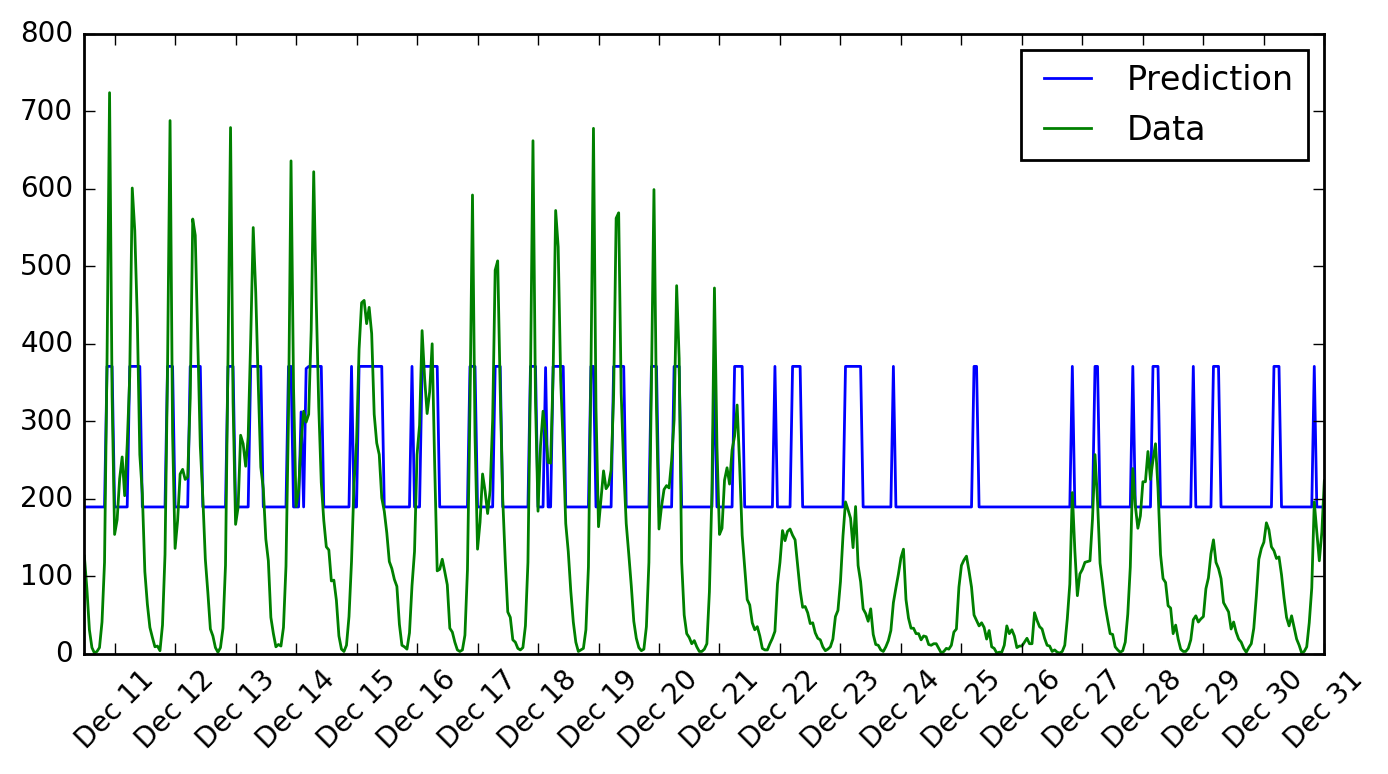

In [39]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(val_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((val_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[validation.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

# Thinking about your results
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below
The model seems to get stuck between two levels. Not really sure whats going on here. I tried adding hidden units to improve the predictions, but it didn't work.